In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
import pydicom
import cv2

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [7]:
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
test_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [8]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [9]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [10]:
def load_dicom(path, size = 64): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [11]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join("../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [12]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [13]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [16]:
IMAGE_SIZE = 64

X, y, train_idt = get_all_data_train("T1wCE")
X_test, test_idt = get_all_data_test("T1wCE")
X.shape, y.shape, train_idt.shape

100%|██████████| 87/87 [00:25<00:00,  3.41it/s]


((16196, 64, 64), (16196,), (16196,))

In [17]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.15)

In [18]:
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [19]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape

(TensorShape([13766, 64, 64, 1]),
 (13766, 2),
 TensorShape([2430, 64, 64, 1]),
 (2430, 2),
 (13766,),
 (2430,))

In [30]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(2, activation='softmax'))
    return model

In [31]:
## Hyper Parameters
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = 13766
N_VAL = 2430

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [35]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

In [36]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
344/344 [==============================] - 101s 291ms/step - loss: 1.0083 - auc: 0.5403 - val_loss: 0.6845 - val_auc: 0.6029
Epoch 2/20
344/344 [==============================] - 101s 294ms/step - loss: 0.6763 - auc: 0.6106 - val_loss: 0.6626 - val_auc: 0.6404
Epoch 3/20
344/344 [==============================] - 99s 288ms/step - loss: 0.6646 - auc: 0.6369 - val_loss: 0.6798 - val_auc: 0.6060
Epoch 4/20
344/344 [==============================] - 98s 286ms/step - loss: 0.6374 - auc: 0.6833 - val_loss: 0.6398 - val_auc: 0.6896
Epoch 5/20
344/344 [==============================] - 98s 286ms/step - loss: 0.5994 - auc: 0.7424 - val_loss: 0.6630 - val_auc: 0.6634
Epoch 6/20
344/344 [==============================] - 99s 286ms/step - loss: 0.5514 - auc: 0.7936 - val_loss: 0.5873 - val_auc: 0.7513
Epoch 7/20
344/344 [==============================] - 98s 285ms/step - loss: 0.4601 - auc: 0.8684 - val_loss: 0.5626 - val_auc: 0.7818
Epoch 8/20
344/344 [==============================] -

In [44]:
# Save the entire model to a HDF5 file
model.save('model.h5')

In [45]:
# Recreate the exact same model, including its weights and the optimizer
new_model = keras.models.load_model('model.h5')
# Show the model architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 256)        

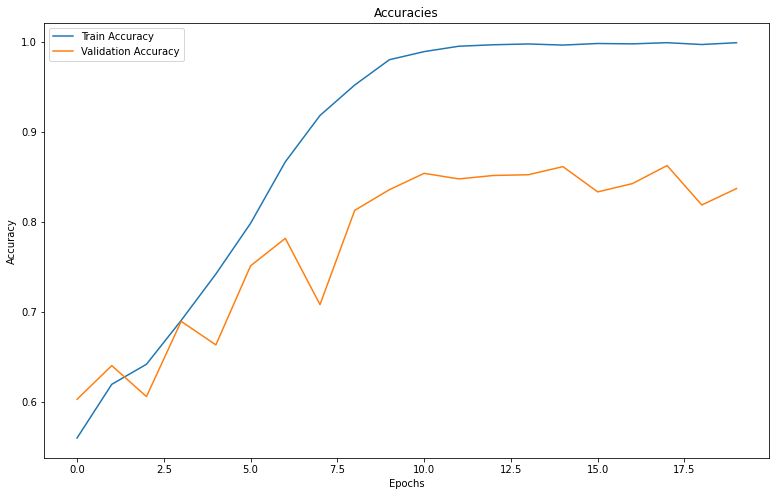

In [48]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc"], label = "Train Accuracy")
plt.plot(history.history["val_auc"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

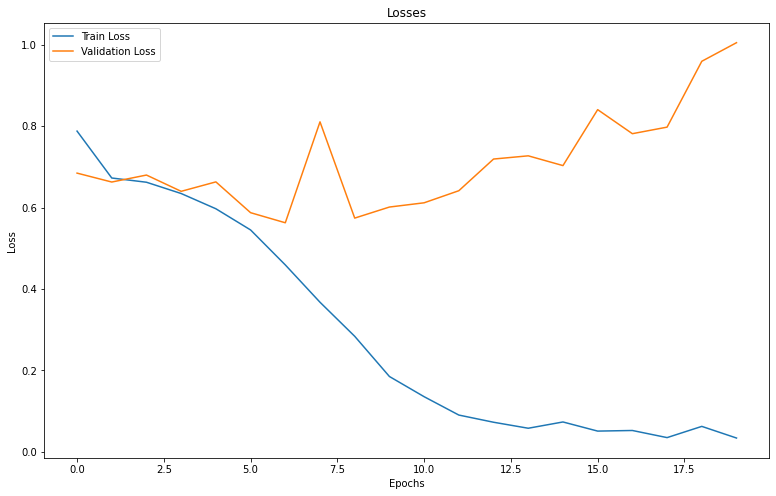

In [49]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]

In [52]:
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

0.8553917462444854

In [58]:
X_test2 = tf.expand_dims(X_test, axis=-1)

In [59]:
#submission
sample_sub = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

y_pred = model.predict(X_test2) #predict test
pred = np.argmax(y_pred, axis = 1)

result = pd.DataFrame(test_idt)
result[1] = pred

result.columns=["BraTS21ID","MGMT_value"]
result_final = result.groupby("BraTS21ID",as_index = False).mean()

result_final["BraTS21ID"] = sample_sub["BraTS21ID"]
result_final["MGMT_value"] = result_final["MGMT_value"]
result_final

,BraTS21ID,MGMT_value
0,1,0.909091
1,13,0.909091
2,15,0.901961
3,27,0.921569
4,37,0.954545
...,...,...
82,826,0.857143
83,829,0.800000
84,833,0.375000
85,997,0.500000


In [60]:
result_final.to_csv("submission.csv",index=False)